# Picking branch effects apart to make a model

## 1 Setup

Flags

In [1]:
SAVE_FIGURES = True

Setup the database

In [2]:
import os, sys
sys.path.insert(1, os.path.abspath('../..'))
import analysis

FIG = os.path.join(os.path.abspath(os.path.curdir), '{}.png')
DB_NAME = 'spreadr_' + os.path.split(os.path.abspath(os.path.curdir))[1]
analysis.setup(DB_NAME)
print('Database:', DB_NAME)

Database: spreadr_exp_3


Imports for the analysis

In [3]:
from collections import Counter, defaultdict
import itertools

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sb
import spacy
from statsmodels.api import Logit
import statsmodels as sm
from statsmodels.stats.proportion import multinomial_proportions_confint
from statsmodels.graphics.mosaicplot import mosaic
from statsmodels.robust.robust_linear_model import RLM
from progressbar import ProgressBar
import lifelines

from gists.models import Sentence, Tree, GistsConfiguration

from analysis.utils import memoized, quantile_interval, get_nlp, token_eq
from analysis.transformations import gaps
from analysis import settings

sb.set()
config = GistsConfiguration.get_solo()
nlp = get_nlp()

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools



## 2 Setup

We need a few helper functions first

In [4]:
def gapless(sequence, idx):
    if token_eq(sequence[idx], settings.ALIGNMENT_GAP_CHAR):
        raise ValueError("index {} is a gap in sequence {}"
                         .format(idx, sequence))
    return idx - int(np.sum([token_eq(el, settings.ALIGNMENT_GAP_CHAR)
                             for el in sequence[:idx]]))

def set_order_array(ids):
    return np.array(list(sorted(set(ids))), dtype=int)


def chunk_indices_with_children_exc(deep_alignments):
    for dal in deep_alignments:
        seq1 = dal['seq1']
        seq2 = dal['seq2']
        subalignments = dal['subalignments']
        
        # Compute this level's app/dis/apprpl/disrpl/stb ids
        base_app_ids = []
        base_dis_ids = []
        base_rpl_pairs = []
        base_stb_pairs = []
        for i, (tok1, tok2) in enumerate(zip(seq1, seq2)):
            if token_eq(tok1, settings.ALIGNMENT_GAP_CHAR):
                assert not token_eq(tok2, settings.ALIGNMENT_GAP_CHAR)
                base_app_ids.append(gapless(seq2, i))
            elif token_eq(tok2, settings.ALIGNMENT_GAP_CHAR):
                assert not token_eq(tok1, settings.ALIGNMENT_GAP_CHAR)
                base_dis_ids.append(gapless(seq1, i))
            elif tok1.lemma == tok2.lemma or tok1.orth == tok2.orth:
                base_stb_pairs.append((gapless(seq1, i), gapless(seq2, i), False))
            else:
                base_rpl_pairs.append((gapless(seq1, i), gapless(seq2, i), False))

        # Check we saw all the parent ids exactly once
        parent_ids = (base_dis_ids +
                      [pid for pid, _, _ in base_rpl_pairs] +
                      [pid for pid, _, _ in base_stb_pairs])
        assert len(set(parent_ids)) == max(parent_ids) + 1
        
        # See if that's all the work we have to do
        if len(subalignments) == 0:
            yield (set_order_array(base_app_ids),
                   set_order_array(base_dis_ids),
                   set_order_array(base_rpl_pairs),
                   set_order_array(base_stb_pairs))
            # Don't recurse more since there are no subalignments.
            # Instead move on to the next deep_alignment.
            continue
            # TODO: propagate this change elsewhere
        
        # Nope, we must combine this level with all the combinations of subalignments
        for subalignment in subalignments:
            
            if len(subalignment) == 0:
                # This subalignment is the base alignment (which was as good as
                # or better than other subalignments)
                yield (set_order_array(base_app_ids),
                       set_order_array(base_dis_ids),
                       set_order_array(base_rpl_pairs),
                       set_order_array(base_stb_pairs))
                continue
            
            # For this mapping, get the list of exchanges and the list of chunk_indices iterators
            # from each exchange
            excs, excs_chunk_indices_iter = zip(*[(exc, chunk_indices_with_children_exc(exc_dals))
                                                  for exc, exc_dals in subalignment.items()])
            # Loop through the product of paths from each exchange
            for excs_chunk_indices_tuple in itertools.product(*excs_chunk_indices_iter):
                app_ids = set(base_app_ids)
                dis_ids = set(base_dis_ids)
                rpl_pairs = set(base_rpl_pairs)
                stb_pairs = set(base_stb_pairs)
                
                for (((start1, stop1), (start2, stop2)),
                     (exc_app_ids, exc_dis_ids, exc_rpl_pairs, exc_stb_pairs)) \
                        in zip(excs, excs_chunk_indices_tuple):
                
                    gapless2_start1 = gapless(seq2, start1)
                    gapless2_stop1 = gapless(seq2, stop1 - 1) + 1
                    gapless1_start2 = gapless(seq1, start2)
                    gapless1_stop2 = gapless(seq1, stop2 - 1) + 1
                    
                    app_ids.difference_update(range(gapless2_start1, gapless2_stop1))
                    dis_ids.difference_update(range(gapless1_start2, gapless1_stop2))
                    
                    app_ids.update(gapless2_start1 + exc_app_ids)
                    dis_ids.update(gapless1_start2 + exc_dis_ids)
                    rpl_pairs.update([(gapless1_start2 + pid, gapless2_start1 + cid, True)
                                      for pid, cid, _ in exc_rpl_pairs])
                    stb_pairs.update([(gapless1_start2 + pid, gapless2_start1 + cid, True)
                                      for pid, cid, _ in exc_stb_pairs])
                
                yield (set_order_array(app_ids),
                       set_order_array(dis_ids),
                       set_order_array(rpl_pairs),
                       set_order_array(stb_pairs))

@memoized
def consensus_chunk_indices_with_children(parent, child):
    all_chunk_indices = list(chunk_indices_with_children_exc(parent.align_deep_lemmas(child)))
    
    consensus_del = []
    consensus_stb_pairs = []
    consensus_rpl_pairs = []
    
    for parent_token_id in range(len(parent.tokens)):
        # See if more than half the deep alignments give the parent_token_id as stable
        da_id_stable = []
        da_id_child = []
        for _, _, rpl_pairs, stb_pairs in all_chunk_indices:
            if len(rpl_pairs) > 0:
                token_rpl = np.where(rpl_pairs[:, 0] == parent_token_id)[0]
            else:
                token_rpl = []
            if len(stb_pairs) > 0:
                token_stb = np.where(stb_pairs[:, 0] == parent_token_id)[0]
            else:
                token_stb = []
            if len(token_rpl) > 0:
                assert len(token_rpl) == 1
                assert len(token_stb) == 0
                da_id_stable.append(True)
                da_id_child.append(rpl_pairs[token_rpl[0], 1])
            elif len(token_stb) > 0:
                assert len(token_rpl) == 0
                assert len(token_stb) == 1
                da_id_stable.append(True)
                da_id_child.append(stb_pairs[token_stb[0], 1])
            else:
                da_id_stable.append(False)

        if np.mean(da_id_stable) >= .5:
            # parent_token_id is stable, so get its majority child
            child_token_id = sorted(Counter(da_id_child).items(), key=lambda t: (t[1], t[0]))[-1][0]
            # TODO: HERE how do you deal with indecision on child-> parent?
            # and store either as stability or replacement
            if (parent.tokens[parent_token_id].lemma != child.tokens[child_token_id].lemma
                    and parent.tokens[parent_token_id].orth != child.tokens[child_token_id].orth):
                # it's a replacement
                consensus_rpl_pairs.append((parent_token_id, child_token_id))
            else:
                # it's a stability
                consensus_stb_pairs.append((parent_token_id, child_token_id))
        else:
            # parent_token_id is not stable
            consensus_del.append(parent_token_id)
    
    # Check for conflicts
    parent2child = np.array(list(itertools.chain(consensus_rpl_pairs, consensus_stb_pairs)))
    if len(set(parent2child[:, 1])) < len(parent2child[:, 1]):
        # We have conflicts, i.e. child tokens assigned to several parent tokens.
        # Remove the parent tokens with smallest ids.
        conflicts_child = [cid for (cid, n_parents) in Counter(parent2child[:, 1]).items()
                           if n_parents >= 2]
        
        for conflict_child in conflicts_child:
            conflict_parents = sorted([pid for (pid, cid) in parent2child
                                       if cid == conflict_child])
            assert len(conflict_parents) == 2, "Triple assignment found!"
            # Remove the lowest parent
            if (conflict_parents[0], conflict_child) in consensus_stb_pairs:
                consensus_stb_pairs.remove((conflict_parents[0], conflict_child))
            elif (conflict_parents[0], conflict_child) in consensus_rpl_pairs:
                consensus_rpl_pairs.remove((conflict_parents[0], conflict_child))
            else:
                raise ValueError("Conflict not found for deletion")
            consensus_del = sorted(consensus_del + [conflict_parents[0]])
    
    # Cleanup and sanity checks
    consensus_stb_pairs = np.array(consensus_stb_pairs)
    consensus_rpl_pairs = np.array(consensus_rpl_pairs)
    consensus_del = np.array(consensus_del)
    assert (sorted(set(consensus_del)
                   .union([pid for pid, _
                           in itertools.chain(consensus_rpl_pairs, consensus_stb_pairs)]))
            == list(range(len(parent.tokens))))
    assert (len(set([cid for _, cid in itertools.chain(consensus_rpl_pairs, consensus_stb_pairs)]))
            == len([cid for _, cid in itertools.chain(consensus_rpl_pairs, consensus_stb_pairs)]))
    
    # Get the insertions
    consensus_ins = set(range(len(child.tokens)))
    if len(consensus_stb_pairs) > 0:
        consensus_ins = consensus_ins.difference(consensus_stb_pairs[:, 1])
    if len(consensus_rpl_pairs) > 0:
        consensus_ins = consensus_ins.difference(consensus_rpl_pairs[:, 1])
    consensus_ins = np.array(sorted(consensus_ins))
    
    return consensus_ins, consensus_del, consensus_rpl_pairs, consensus_stb_pairs

def contiguous_chunks(ids):
    """Get the list of contiguous chunks in `ids`.
    
    A contiguous chunk here is a suite of ids that follow each other.
    If `ids` is empty, returns an empty list.
    
    """
    
    assert len(set(ids)) == len(ids)
    ids = sorted(ids)
    if len(ids) == 0:
        return []
    
    chunks = []
    chunk = [ids[0]]
    
    for id in ids[1:]:
        if id == max(chunk) + 1:
            chunk.append(id)
        else:
            chunks.append(chunk)
            chunk = [id]
    
    chunks.append(chunk)
    return chunks

In [5]:
def branch_sentences(sentence, with_root=False, with_leaf=True):
    # Walk back up to the head of the branch
    head = sentence.head
    
    if with_root:
        yield head.parent
    
    current = head
    while current.children.kept.count() > 0 and current.depth < config.target_branch_depth:
        if current.children.kept.count() > 1:
            raise ValueError("More than one (kept) children for sentence {}"
                             .format(current.id))
        yield current
        current = current.children.kept.first()
    
    if with_leaf:
        # Yield the final leaf
        yield current

In [6]:
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)

In [7]:
def plot_int_dist(x, scale=None, ax=None,
                  plot_kws={'marker': 'o', 'lw': 0}, hist_kws={},
                  **kws):
    assert scale in [None, 'ylog', 'loglog'], scale
    
    bins = np.linspace(x.min() -.5, x.max() + .5, int(x.max() - x.min() + 2))
    middles = (bins[1:] + bins[:-1]) / 2
    hist, _ = np.histogram(x, bins=bins, **hist_kws)
    
    if ax is None:
        ax = plt.gca()
    ax.plot(middles, hist, **plot_kws, **kws)
    if scale == 'ylog':
        ax.set_yscale('log')
    if scale == 'loglog':
        ax.set_xscale('log')
        ax.set_yscale('log')
    ax.locator_params(subs='all')
    return ax

Check our consensus alignments are consistent both ways

In [8]:
for tree in ProgressBar(max_value=Tree.objects.experiment.count())(Tree.objects.experiment):
    for head in tree.root.children.kept:
        for parent, child in pairwise(branch_sentences(head, with_root=True, with_leaf=True)):
            ins_ids, del_ids, rpl_pairs, stb_pairs = consensus_chunk_indices_with_children(parent, child)
            ins_ids2, del_ids2, rpl_pairs2, stb_pairs2 = consensus_chunk_indices_with_children(child, parent)
            np.testing.assert_equal(ins_ids, del_ids2, (parent.id, child.id))
            np.testing.assert_equal(del_ids, ins_ids2, (parent.id, child.id))
            np.testing.assert_equal(rpl_pairs,
                                    np.array(sorted([[p[1], p[0]]
                                                     for p in rpl_pairs2])),
                                    (parent.id, child.id))
            np.testing.assert_equal(stb_pairs,
                                    np.array(sorted([[p[1], p[0]]
                                                     for p in stb_pairs2])),
                                    (parent.id, child.id))
            

100% (50 of 50) |#########################| Elapsed Time: 0:04:58 Time: 0:04:58


Now build the master DataFrame that we plot below

In [9]:
data = []
for tree in ProgressBar(max_value=Tree.objects.experiment.count())(Tree.objects.experiment):
    
    for head in tree.root.children.kept:
        
        for parent, child in pairwise(branch_sentences(head, with_root=True, with_leaf=True)):
            
            app_ids, dis_ids, rpl_pairs, stb_pairs = \
                consensus_chunk_indices_with_children(parent, child)
            
            data.append({
                'tree_id': tree.id,
                'branch_id': head.id,
                'parent_id': parent.id,
                'child_id': child.id,

                'parent_depth': parent.depth,
                'parent_length': len(parent.tokens),

                'del_count': len(dis_ids),
                'ins_count': len(app_ids),
                'rpl_count': len(rpl_pairs),
                'stb_count': len(stb_pairs),
                
                'del_chunk_count': len(contiguous_chunks(dis_ids)),
                'ins_chunk_count': len(contiguous_chunks(app_ids)),
                'rpl_parent_chunk_count': len(contiguous_chunks([p[0] for p in rpl_pairs])),
                #'rpl_child_chunk_count':
                'stb_parent_chunk_count': len(contiguous_chunks([p[0] for p in stb_pairs])),
                #'stb_child_chunk_count':
            })

data = pd.DataFrame(data)

100% (50 of 50) |#########################| Elapsed Time: 0:00:25 Time: 0:00:25


## 3 Counts

Prepare some data values

In [10]:
data['del_count_rel'] = data.del_count / data.parent_length
data['stb_count_rel'] = data.stb_count / data.parent_length

# We ignore exchanges as operations
has_transformation = ((data.del_count > 0)
                      | (data.ins_count > 0)
                      | (data.rpl_count > 0))
unique_transformation = (has_transformation
                         & (((data.del_count == 0) & (data.ins_count == 0))
                            | ((data.del_count == 0) & (data.rpl_count == 0))
                            | ((data.ins_count == 0) & (data.rpl_count == 0))))

data['has_del'] = data.del_count > 0
data['has_ins'] = data.ins_count > 0
data['has_rpl'] = data.rpl_count > 0

columns_count = ['del_count',
                 'ins_count',
                 'rpl_count',
                 'stb_count']
columns_count_rel = ['del_count_rel',
                     'stb_count_rel']
columns_chunk = ['del_chunk_count',
                 'ins_chunk_count',
                 'rpl_parent_chunk_count',
                 'stb_parent_chunk_count']
max_count = data[columns_count].max().max()
max_count_rel = data[columns_count_rel].max().max()
max_chunk = data[columns_chunk].max().max()

We're going to ignore exchanges, so that our ontology of possible transformations is: deletion, insertion, replacement, stability.

However we keep from exchanges the fact that words are stable or replaced. We just drop the change in index.

### Counts

Contingency table for all our transformations:

In [11]:
contingencies_delinsrpl = data['del_count']\
    .groupby([(data.del_count > 0), (data.ins_count > 0), (data.rpl_count > 0)])\
    .count()\
    .rename_axis(['Deletion', 'Insertion', 'Replacement'])
contingencies_delinsrpl

Deletion  Insertion  Replacement
False     False      False          1381
                     True            415
          True       False            66
                     True             94
True      False      False           286
                     True            308
          True       False           399
                     True            512
Name: del_count, dtype: int64

In [12]:
contingencies_delinsrpl.rename(index=lambda l: 'Yes' if l else 'No').unstack([0, 2])

Deletion       No       Yes     
Replacement    No  Yes   No  Yes
Insertion                       
No           1381  415  286  308
Yes            66   94  399  512

In [13]:
contingencies_delinsrpl = contingencies_delinsrpl.reindex([(d, i, r)
                                                           for d in [False, True]
                                                           for i in [True, False]
                                                           for r in [False, True]])

for lvl, name in enumerate(['D', 'I', 'R']):
    contingencies_delinsrpl.rename(level=lvl,
                                   index=lambda l: '$' + ('' if l else '\\neg ') + name + '$',
                                   inplace=True)
contingencies_delinsrpl

Deletion  Insertion  Replacement
$\neg D$  $I$        $\neg R$         66
                     $R$              94
          $\neg I$   $\neg R$       1381
                     $R$             415
$D$       $I$        $\neg R$        399
                     $R$             512
          $\neg I$   $\neg R$        286
                     $R$             308
Name: del_count, dtype: int64

In [14]:
blue, green, red, purple, yellow, cyan = sb.color_palette()

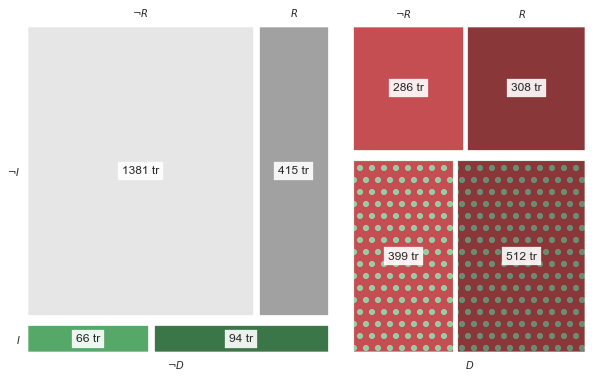

In [15]:
def darken(color, p):
    return [c * p for c in color]

def lighten(color, p):
    return [c + (1 - c) * p for c in color]

def get_props(k):
    k0, k1, k2 = k
    if k0 == '$D$':
        fc = red
        if k1 == '$I$':
            ec = lighten(green, .4)
        else:
            ec = fc
    elif k1 == '$I$':
        fc = green
        ec = green
    else:
        fc = (0.9, 0.9, 0.9)
        ec = fc
    if k2 == '$R$':
        fc = darken(fc, .7)
        ec = darken(ec, .7)
    return {'facecolor': fc, 'edgecolor': ec, 'hatch': '.o'}

with sb.axes_style('white', {'axes.edgecolor': '1'}):
    fig, ax = plt.subplots(figsize=(10, 6))
    _, rects = mosaic(contingencies_delinsrpl,
                      gap=.05, ax=ax,
                      properties=get_props,
                      labelizer=lambda k: '');
    for k, (x, y, w, h) in rects.items():
        # Add transformation count
        ax.text(x + w / 2, y + h / 2, '{} tr'.format(contingencies_delinsrpl[k]),
                va='center', ha='center',
                bbox=dict(facecolor='white', edgecolor='white', alpha=0.9))
        # Also add the missing title at the top right
        if k[0] == '$D$' and k[1] == '$I$':
            ax.text(x + w / 2, 1.02, k[2], va='bottom', ha='center', fontsize=10)

if SAVE_FIGURES:
    fig.savefig(FIG.format('contingencies_mosaic'), dpi=300, bbox_inches='tight')

## 4 Insertions depending on deletions

Without deletion, insertion has very low probability. With insertion, deletion has very high probability. One way to see this is to look at deletions first, and then look at the distribution of insertions. Below we compare the distribution of insertions without and with deletion:

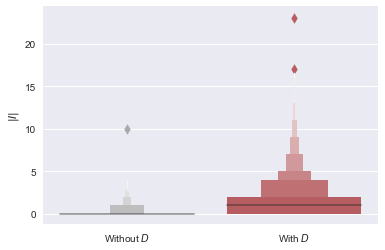

In [16]:
ax = sb.lvplot(y='ins_count', x='has_del', data=data, palette=['darkgrey', red])
ax.set_xlabel('')
ax.set_xticklabels([r'Without $D$', 'With $D$'])
ax.set_ylabel('$|I|$')
if SAVE_FIGURES:
    ax.figure.savefig(FIG.format('insertion-lv_del-presence'), dpi=300, bbox_inches='tight')

## 5 Link between insertion and deletion size

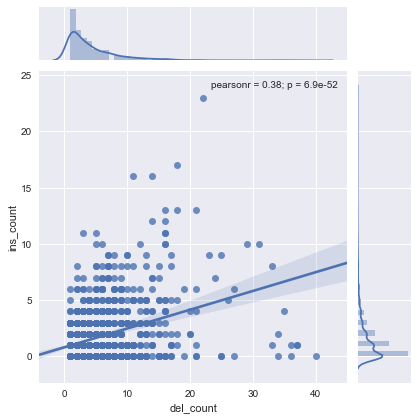

In [17]:
sb.jointplot(x='del_count', y='ins_count', data=data[(data.del_count > 0)], kind='reg')

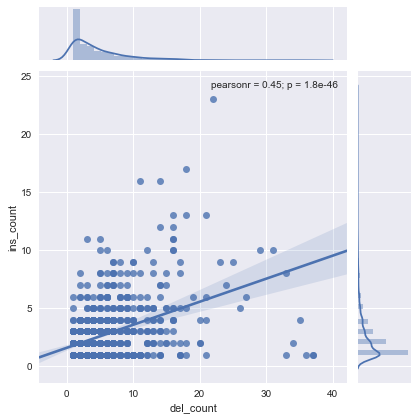

In [18]:
sb.jointplot(x='del_count', y='ins_count', data=data[(data.del_count > 0) & (data.ins_count > 0)], kind='reg')

In [19]:
def chunk_pos_size(index, ids):
    for chunk in contiguous_chunks(ids):
        if index in chunk:
            return (min(chunk), len(chunk))
    raise IndexError("{} not found in {}".format(index, ids))

In [20]:
def find_nearest_delchunk(child_start, dis_ids, rpl_pairs, stb_pairs, direction):
    assert direction in [-1, 1]
    
    # Get the full array of ids involved in exchanges
    exc_pairs = set()
    for (p1, c1), (p2, c2) in itertools.product(itertools.chain(rpl_pairs, stb_pairs), repeat=2):
        if ((p1 < p2) and (c1 > c2)) or ((p1 > p2) and (c1 < c2)):
            exc_pairs.add((p1, c1))
            exc_pairs.add((p2, c2))
    child2parent = dict((cid, pid) for pid, cid
                        in itertools.chain(rpl_pairs, stb_pairs)
                        if (pid, cid) not in exc_pairs)
    
    # Check our first neighbour
    if child_start + direction not in child2parent:
        return None
    
    # Check whatever is facing child_start
    facing = child2parent[child_start + direction] - direction
    if facing in dis_ids:
        return (0,) + chunk_pos_size(facing, dis_ids)
    
    # Walk down the neighbours
    current = child_start + direction
    while current in child2parent:
        # Check the neighbour of our current index
        parent_neighbour = child2parent[current] + direction
        if parent_neighbour in dis_ids:
            return (current - child_start,) + chunk_pos_size(parent_neighbour, dis_ids)
        current += direction
    
    return None

In [21]:
data_corresp = []
for tree in ProgressBar(max_value=Tree.objects.experiment.count())(Tree.objects.experiment):
    
    for head in tree.root.children.kept:
        
        for parent, child in pairwise(branch_sentences(head, with_root=True, with_leaf=True)):
            
            app_ids, dis_ids, rpl_pairs, stb_pairs = \
                consensus_chunk_indices_with_children(parent, child)
            
            tr_corresp = defaultdict(dict)
            del_pos_doubly_attributed = set()
            
            for inschunk in contiguous_chunks(app_ids):
                nearest_left = find_nearest_delchunk(inschunk[0], dis_ids, rpl_pairs, stb_pairs, -1)
                nearest_right = find_nearest_delchunk(inschunk[-1], dis_ids, rpl_pairs, stb_pairs, 1)
                
                if nearest_left is None:
                    if nearest_right is None:
                        distance = np.nan
                        del_pos = np.nan
                        del_size = np.nan
                    else:
                        distance, del_pos, del_size = nearest_right
                else:
                    if nearest_right is None:
                        distance, del_pos, del_size = nearest_left
                    else:
                        if abs(nearest_left[0]) <= abs(nearest_right[0]):
                            distance, del_pos, del_size = nearest_left
                        else:
                            distance, del_pos, del_size = nearest_right
                
                ins_pos = inschunk[0]
                row = {
                    'tree_id': tree.id,
                    'branch_id': head.id,
                    'parent_id': parent.id,
                    'child_id': child.id,

                    'parent_depth': parent.depth,
                    'parent_length': len(parent.tokens),
                    
                    'distance': distance,
                    'ins_size': len(inschunk),
                    'ins_pos': ins_pos,
                    'del_size': del_size,
                    'del_pos': del_pos,
                }
                
                if np.isnan(del_pos):
                    assert ins_pos not in tr_corresp[del_pos]
                    tr_corresp[del_pos][ins_pos] = row
                else:
                    if del_pos in tr_corresp:
                        # This non-nan del_pos was already attributed to an insertion.
                        # This should happen at most once per deletion chunk.
                        assert del_pos not in del_pos_doubly_attributed
                        del_pos_doubly_attributed.add(del_pos)
                        # Get the previous ins_pons
                        del_pos_ins_poses = list(tr_corresp[del_pos].keys())
                        assert len(del_pos_ins_poses) == 1
                        prev_ins_pos = del_pos_ins_poses[0]

                        if abs(distance) <= abs(tr_corresp[del_pos][prev_ins_pos]['distance']):
                            # This new attribution of del_pos in closer,
                            # or at the same distance but comes afterwards,
                            # so we switch to this one.
                            del tr_corresp[del_pos][prev_ins_pos]
                            tr_corresp[del_pos][ins_pos] = row
                        else:
                            # Don't store this second attribution
                            pass
                    else:
                        tr_corresp[del_pos][ins_pos] = row
            
            for del_pos, rows in tr_corresp.items():
                if not np.isnan(del_pos):
                    assert len(rows) == 1
                data_corresp.extend(rows.values())

data_corresp = pd.DataFrame(data_corresp).dropna()
data_corresp['abs_distance'] = abs(data_corresp.distance)

100% (50 of 50) |#########################| Elapsed Time: 0:00:25 Time: 0:00:25


In [22]:
data_corresp_d_sizes = data_corresp.groupby('distance').size()
data_corresp_d_sizes

distance
-18.0      2
-16.0      1
-15.0      1
-12.0      1
-11.0      3
-10.0      2
-9.0       2
-8.0       1
-7.0       2
-6.0       7
-5.0      11
-4.0      10
-3.0      14
-2.0      37
-1.0      69
 0.0     762
 1.0      54
 2.0      24
 3.0      16
 4.0      16
 5.0      12
 6.0       8
 7.0       2
 8.0       4
 9.0       2
 12.0      1
 13.0      1
 17.0      1
 19.0      2
dtype: int64

Keep only the distances for which we have at least 10 points

In [23]:
distances = np.array(data_corresp_d_sizes[data_corresp_d_sizes >= 10].index)
distances

array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.])

Build the figure with robust regressions

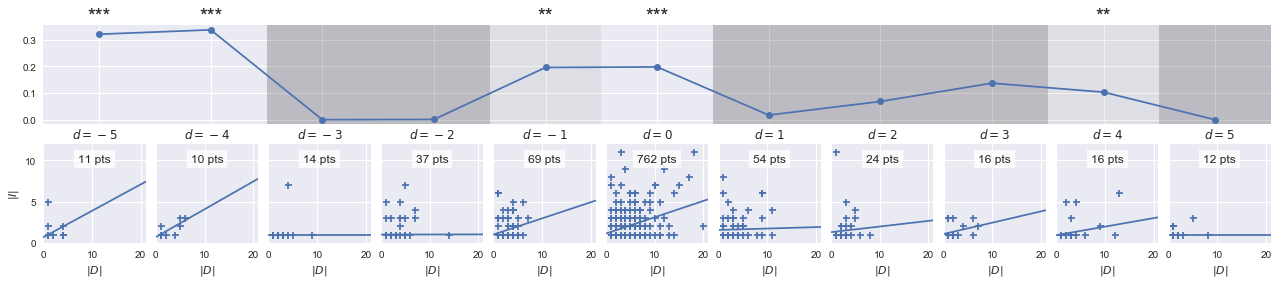

In [24]:
ax_size = 2
fig, axes = plt.subplots(2, len(distances), figsize=(ax_size * len(distances), ax_size * 2),
                         sharex=True, sharey=True, gridspec_kw={'wspace': .1})
for ax in axes[0, :]:
    ax.axis('off')

xlim_regs = np.array([data_corresp[data_corresp.distance == 0].del_size.min() - 1,
                      data_corresp[data_corresp.distance == 0].del_size.max() + 1])
ylim_regs = np.array([data_corresp[data_corresp.distance == 0].ins_size.min() - 1,
                      data_corresp[data_corresp.distance == 0].ins_size.max() + 1])
axes[1, 0].set_xlim(xlim_regs)
axes[1, 0].set_ylim(ylim_regs)

slopes = np.ones_like(distances) * np.nan
pvalues = np.ones_like(distances) * np.nan

for i, d in enumerate(distances):
    endog = data_corresp[data_corresp.distance == d].ins_size
    # Add a tiny noise to avoid https://github.com/statsmodels/statsmodels/issues/55
    endog += 1e-7 * np.random.normal(size=endog.shape)
    exog = data_corresp[data_corresp.distance == d].del_size
    exog = sm.tools.add_constant(exog)
    res = RLM(endog, exog).fit()
    slopes[i] = res.params['del_size']
    pvalues[i] = res.pvalues['del_size']

    axes[1, i].scatter(exog.del_size, endog, marker='+')
    axes[1, i].plot(xlim_regs, res.params['const'] + res.params['del_size'] * xlim_regs)
    axes[1, i].set_title('$d = {}$'.format(int(d)))
    axes[1, i].text(xlim_regs.mean(), ylim_regs[1] * .9, '{} pts'.format(len(endog)),
                    ha='center', va='top',
                    bbox=dict(facecolor='white', edgecolor='white', alpha=0.8))
    axes[1, i].set_xlabel('$|D|$')
    if i == 0:
        axes[1, i].set_ylabel('$|I|$')

ax_synth = plt.subplot2grid((2, len(distances)), (0, 0), colspan=len(distances))
ax_synth.plot(distances, slopes, 'o-')
ax_synth.set_xlim(distances.min() - .5, distances.max() + .5)
ylim = ax_synth.get_ylim()
for d, p in zip(distances, pvalues):
    if np.isnan(p):
        continue
    if p < .001:
        alpha = 0
        t = '***'
    elif p < .01:
        alpha = .05
        t = '**'
    elif p < .05:
        alpha = .1
        t = '*'
    else:
        alpha = .2
        t = ''
    ax_synth.bar(bottom=ylim[0], height=ylim[1] - ylim[0], left=d, width=1, alpha=alpha, color='black')
    ax_synth.text(d, ylim[1], t, va='bottom', ha='center', fontsize=20)
ax_synth.set_ylim(ylim)
ax_synth.locator_params(axis='x', min_n_ticks=10)
ax_synth.set_xticklabels([])

if SAVE_FIGURES:
    fig.savefig(FIG.format('insdel_distance_size'), dpi=300, bbox_inches='tight')

## 7 Increase/decrease in sentence size

It looks like when there are more insertions than deletions (i.e. the length of the sentence increases), a shortening happens quickly after that. Here we try to test that.

In [25]:
increase = (data.ins_count > data.del_count)
follow_increase = pd.Series(index=data.index, data=False)
for branch_id, depth in zip(data[increase].branch_id, data[increase].parent_depth):
    follow_increase = follow_increase | ((data.branch_id == branch_id) & (data.parent_depth == depth + 1))

In [26]:
data['increase'] = increase
data['follow_increase'] = follow_increase

Here's the distribution of deletions right after an increase in length, vs. not:

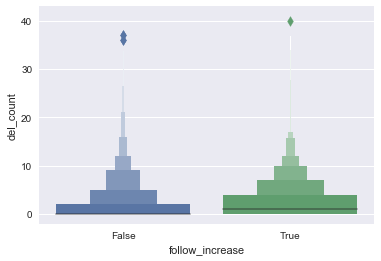

In [27]:
sb.lvplot(x='follow_increase', y='del_count', data=data)

And here's the regression of the size of length increase vs. the size of the deletion that follows it:

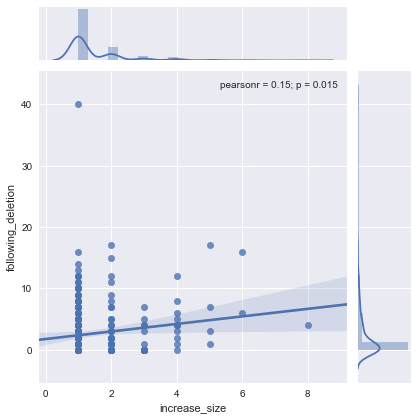

In [28]:
increase_pairs = []
for i, (branch_id, depth) in enumerate(zip(data[follow_increase].branch_id,
                                           data[follow_increase].parent_depth)):
    increase_pairs.append({
        'increase_size': (data[(data.branch_id == branch_id)
                               & (data.parent_depth == depth - 1)].ins_count.iloc[0]
                          - data[(data.branch_id == branch_id)
                                 & (data.parent_depth == depth - 1)].del_count.iloc[0]),
        'following_deletion': data[(data.branch_id == branch_id)
                                   & (data.parent_depth == depth)].del_count.iloc[0]
    })
increase_pairs = pd.DataFrame(increase_pairs)
sb.jointplot(x='increase_size', y='following_deletion', data=increase_pairs, kind='reg')

Not a strong correlation.

## 8 Position in sentence

Prepare the data

In [29]:
data_position = []
for tree in ProgressBar(max_value=Tree.objects.experiment.count())(Tree.objects.experiment):
    
    for head in tree.root.children.kept:
        
        for parent, child in pairwise(branch_sentences(head, with_root=True, with_leaf=True)):
            
            app_ids, dis_ids, rpl_pairs, stb_pairs = \
                consensus_chunk_indices_with_children(parent, child)
            
            for tipe, ref_sentence, ids in \
                    [('del', parent, dis_ids),
                     ('ins', child, app_ids),
                     ('rpl_parent', parent, [p[0] for p in rpl_pairs]),
                     ('rpl_child', child, [p[1] for p in rpl_pairs]),
                     ('stb_parent', parent, [p[0] for p in stb_pairs]),
                     ('stb_child', child, [p[1] for p in stb_pairs])]:
                left_indices = set(range(len(ref_sentence.tokens)))
                for chunk in contiguous_chunks(ids):
                    for i, index in enumerate(chunk):
                        left_indices.remove(index)
                        ref_start_quantile, ref_stop_quantile = \
                            quantile_interval(np.arange(len(ref_sentence.tokens)), index)
                        data_position.append({
                            'tree_id': tree.id,
                            'branch_id': head.id,
                            'parent_id': parent.id,
                            'child_id': child.id,

                            'parent_depth': parent.depth,
                            'parent_length': len(parent.tokens),
                            'ref_sentence_length': len(ref_sentence.tokens),

                            'tipe': tipe,
                            'target': True,
                            'position': index,
                            'position_rel': index / (len(ref_sentence.tokens) - 1),
                            'position_start_quantile': ref_start_quantile,
                            'position_stop_quantile': ref_stop_quantile,
                        })
                for index in left_indices:
                    ref_start_quantile, ref_stop_quantile = \
                        quantile_interval(np.arange(len(ref_sentence.tokens)), index)
                    data_position.append({
                        'tree_id': tree.id,
                        'branch_id': head.id,
                        'parent_id': parent.id,
                        'child_id': child.id,

                        'parent_depth': parent.depth,
                        'parent_length': len(parent.tokens),
                        'ref_sentence_length': len(ref_sentence.tokens),

                        'tipe': tipe,
                        'target': False,
                        'position': index,
                        'position_rel': index / (len(ref_sentence.tokens) - 1),
                        'position_start_quantile': ref_start_quantile,
                        'position_stop_quantile': ref_stop_quantile,
                    })

data_position = pd.DataFrame(data_position)
columns_position = ['del', 'ins', 'rpl_parent', 'rpl_child', 'stb_parent', 'stb_child']

100% (50 of 50) |#########################| Elapsed Time: 0:00:44 Time: 0:00:44


In [30]:
tipe_to_tex = {
    'del': r'$\mathcal{D}$',
    'ins': r'$\mathcal{I}$',
    'rpl_parent': r'$\mathcal{R}_p$',
    'rpl_child': r'$\mathcal{R}_c$'
}

In [31]:
columns_position_r = [tipe_to_tex.get(t, t) for t in columns_position]
data_position['tipe_r'] = data_position.tipe.apply(lambda t: tipe_to_tex.get(t, t))

In [32]:
blue, green, red, purple, yellow, cyan = sb.color_palette()

In [33]:
sentence_lengths = np.array([len(s.parent.tokens)
                             for s in Sentence.objects.experiment.kept.filter(parent__isnull=False)
                             if s.depth <= config.target_branch_depth])

In [34]:
long_sentence = None
_, sentence_bins = pd.qcut(sentence_lengths, 5, retbins=True)
sentence_bins = sentence_bins.astype(int)
sentence_bins

array([ 5, 11, 15, 18, 22, 70])

### Preliminary: probability of a transformation for a given parent length

In [35]:
tr_prob = data_position.groupby(['child_id', 'tipe_r', 'tipe', 'parent_length'])\
    .target\
    .aggregate(lambda x: bool(x.sum() > 0))\
    .reset_index()

Now the distributions of positions of all words in transformations

In [36]:
data_position['weight_all'] = 1
data_position['weight_target'] = data_position.target.astype(np.float)

data_position.weight_all = data_position\
    .groupby(['child_id', 'tipe'])\
    .weight_all\
    .transform(lambda x: x / x.sum())

data_position.weight_target = data_position\
    .groupby(['child_id', 'tipe'])\
    .weight_target\
    .transform(lambda x: x / ((data_position.loc[x.index].target * x).sum() or 1))
assert np.isnan(data_position.weight_target).sum() == 0

In [37]:
def bound(limits, values):
    left, right = limits
    assert left < right
    return np.maximum(left, np.minimum(right, values))

def plot_sentencequantile_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    bin_count = kwargs.get('bins', 5)
    ax = kwargs.get('ax', plt.gca())
    
    # Compute bin heights
    heights = np.zeros(bin_count)
    h0s = np.zeros(bin_count)
    step = 1 / bin_count
    for i in range(bin_count):
        limits = [i * step, (i + 1) * step]
        contributions = ((bound(limits, data['position_stop_quantile'])
                          - bound(limits, data['position_start_quantile']))
                         / (data['position_stop_quantile'] - data['position_start_quantile']))
        heights[i] = (contributions * data.weight_target * data.target).sum()
        h0s[i] = (contributions * data.weight_all).sum()
    total = sum(heights)
    total_h0 = sum(h0s)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total_h0 / h0s[:, np.newaxis])
    
    # Plot them.
    x = np.linspace(0, 1, bin_count)
    ax.plot(x, (heights / total) / (h0s / total_h0),
            color=color)
    ax.fill_between(x, cis[:, 0], cis[:, 1],
                    color=sb.desaturate(color, 0.2), alpha=0.2)
    ax.plot(x, np.ones_like(h0s), '--',
            color=sb.desaturate(color, 0.2))
    ax.set_xlim(x[0], x[-1])
    ax.set_yscale('log')

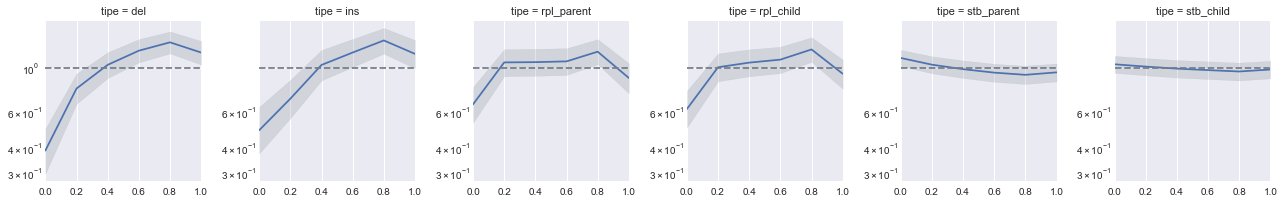

In [38]:
g = sb.FacetGrid(data=data_position, dropna=False,
                 col='tipe', col_order=columns_position,
                 size=3, sharex=True, sharey=True)
g.map_dataframe(plot_sentencequantile_susties, bins=6)

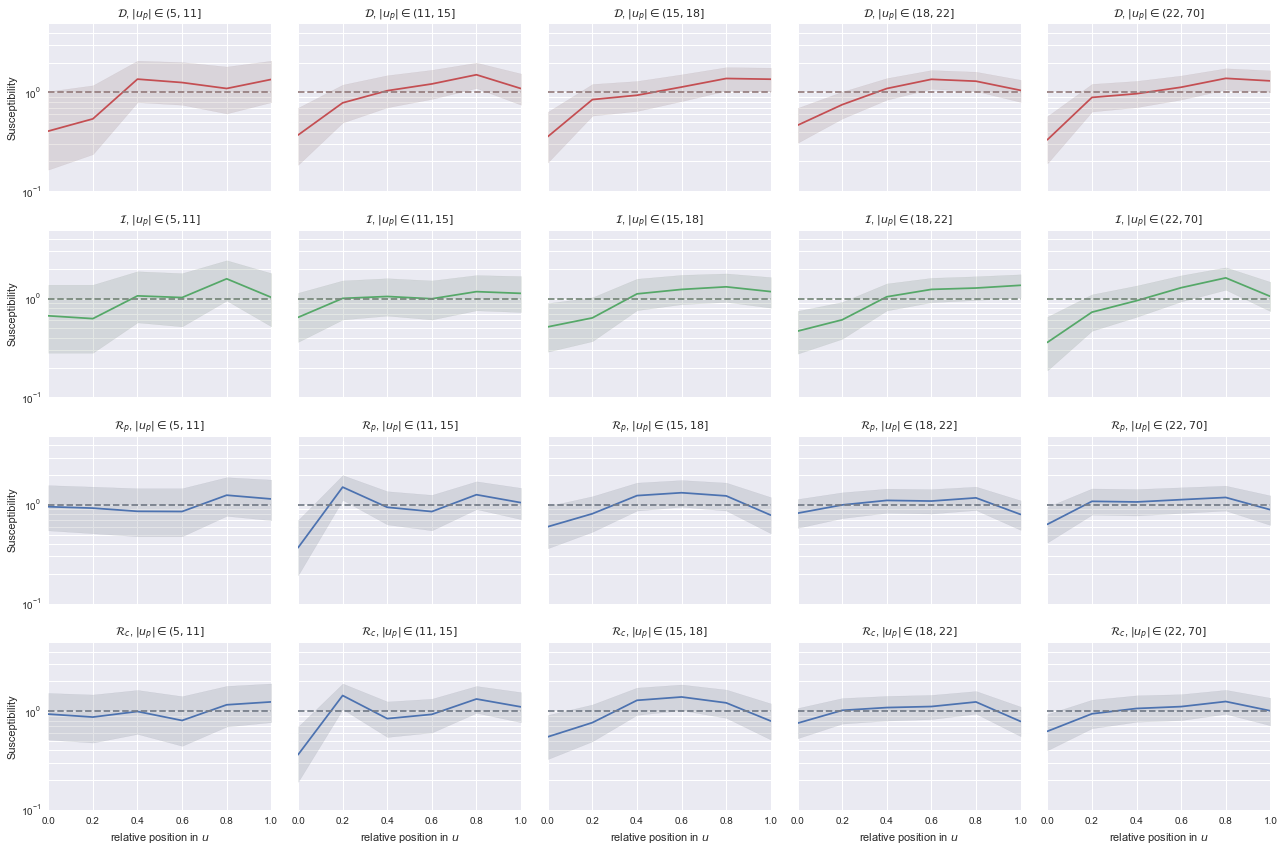

In [39]:
data_position['parent_length_bin'] = pd.cut(data_position.parent_length, sentence_bins)

g = sb.FacetGrid(data=data_position,#[data_position.parent_length <= long_sentence],
                 row='tipe_r', row_order=columns_position_r[:4],
                 hue='tipe_r', hue_order=columns_position_r[:4],
                 palette=[red, green, blue, blue],
                 col='parent_length_bin',
                 size=3, aspect=1.2,
                 sharex=True, sharey=True)
g.map_dataframe(plot_sentencequantile_susties, bins=6)
g.set_titles('{row_name}, $|u_p| \\in {col_name}$')
g.set_ylabels('Susceptibility')
g.set_xlabels('relative position in $u$')
g.set(ylim=(0.1, 5))
for ax in g.axes.ravel():
    ax.locator_params(subs='all')
    ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
g.fig.tight_layout()

### Paper figures

In [40]:
tr_prob = sm.tools.add_constant(tr_prob)

for tipe in columns_position[:3]:
    print('===')
    print(tipe)
    print('===')
    logit = Logit(tr_prob[tr_prob.tipe == tipe].target,
                  tr_prob[tr_prob.tipe == tipe][['const', 'parent_length']])
    res = logit.fit()
    print(res.summary())
    print('Inflexion =', - res.params[0] / res.params[1])
    print()

===
del
===
Optimization terminated successfully.
         Current function value: 0.593063
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 3461
Model:                          Logit   Df Residuals:                     3459
Method:                           MLE   Df Model:                            1
Date:                Sat, 05 Aug 2017   Pseudo R-squ.:                  0.1338
Time:                        00:40:52   Log-Likelihood:                -2052.6
converged:                       True   LL-Null:                       -2369.5
                                        LLR p-value:                7.274e-140
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -2.6826      0.124    -21.564      0.000      -2.926      -2.439
parent_l

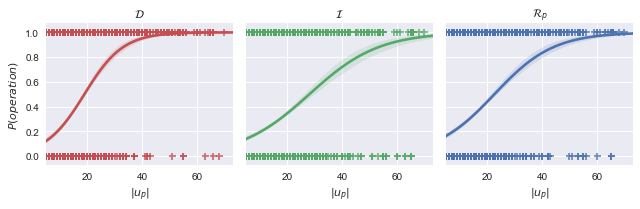

In [41]:
g = sb.FacetGrid(data=tr_prob,
                 col='tipe_r', col_order=columns_position_r[:3],
                 hue='tipe_r', hue_order=columns_position_r[:3],
                 palette=[red, green, blue],
                 sharex=True, sharey=True)
g.map(sb.regplot, 'parent_length', 'target', logistic=True, marker='+')
g.set_titles('{col_name}')
g.set_xlabels(r'$|u_p|$')
g.set_ylabels(r'$P(operation)$')
g.set(xlim=(5, None))
#g.add_legend(title='Operation')
if SAVE_FIGURES:
    g.fig.savefig(FIG.format('p-ops_parent-length_logistic'), dpi=300, bbox_inches='tight')

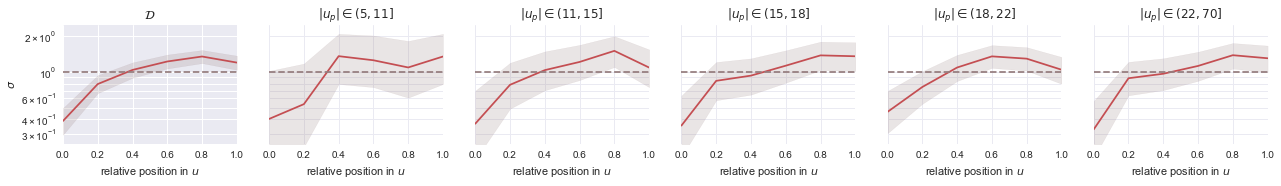

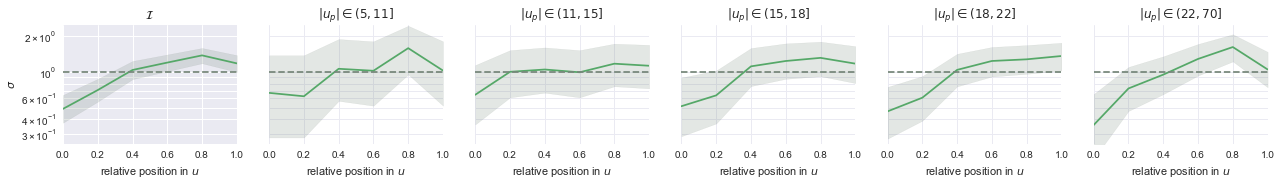

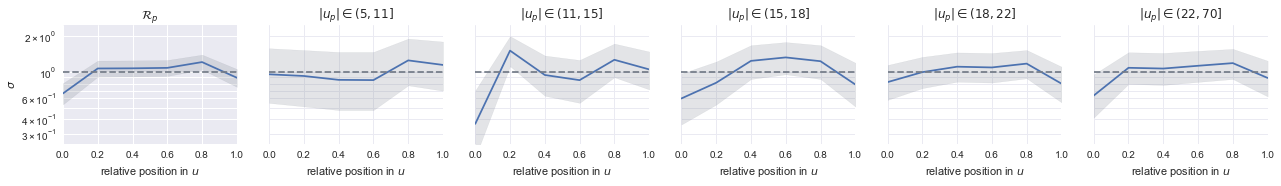

In [42]:
for tipe, tipe_r, color in zip(columns_position[:3], columns_position_r[:3], [red, green, blue]):
    fig, axes = plt.subplots(1, 6, figsize=(18, 2.75), sharex=True, sharey=True)
    
    plot_sentencequantile_susties(data=data_position[(data_position.tipe_r == tipe_r)],
                                  bins=6, color=color, ax=axes[0])
    axes[0].set_ylim(.25, 2.5)
    axes[0].set_title(tipe_r)
    axes[0].set_xlabel('relative position in $u$')
    axes[0].set_ylabel(r'$\sigma$')
    
    for i, sbin in enumerate(sorted(set(data_position.parent_length_bin).difference([np.nan]))):
        plot_sentencequantile_susties(data=data_position[#(data_position.parent_length <= long_sentence) &
                                                         (data_position.tipe_r == tipe_r)
                                                         & (data_position.parent_length_bin == sbin)],
                                      bins=6, color=color, ax=axes[i+1])
        axes[i+1].set_title('$|u_p| \\in {}$'.format(sbin))
        axes[i+1].set_xlabel('relative position in $u$')
        axes[i+1].set_facecolor('white')
        axes[i+1].grid(color='#EAEAF2')
    
    for ax in axes:
        ax.locator_params(subs='all')
        ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    
    fig.tight_layout()
    
    if SAVE_FIGURES:
        fig.savefig(FIG.format('susceptibility-{}_position_parent-length'.format(tipe)),
                    dpi=300, bbox_inches='tight')

## 9 Distributions of word-operations/#chunks/chunk-sizes

Prepare the data

In [43]:
data_size = []
for tree in ProgressBar(max_value=Tree.objects.experiment.count())(Tree.objects.experiment):
    
    for head in tree.root.children.kept:
        
        for parent, child in pairwise(branch_sentences(head, with_root=True, with_leaf=True)):

            app_ids, dis_ids, rpl_pairs, stb_pairs = \
                consensus_chunk_indices_with_children(parent, child)
            
            for tipe, ref_sentence, ids in \
                [('del', parent, dis_ids),
                 ('ins', child, app_ids),
                 ('rpl_parent', parent, [p[0] for p in rpl_pairs]),
                 ('rpl_child', child, [p[1] for p in rpl_pairs]),
                 ('stb_parent', parent, [p[0] for p in stb_pairs]),
                 ('stb_child', child, [p[1] for p in stb_pairs])]:
                chunks = contiguous_chunks(ids)
                for chunk in chunks:
                    data_size.append({
                        'tree_id': tree.id,
                        'branch_id': head.id,
                        'parent_id': parent.id,
                        'child_id': child.id,

                        'parent_depth': parent.depth,
                        'parent_length': len(parent.tokens),
                        'ref_sentence_length': len(ref_sentence.tokens),

                        'tipe': tipe,
                        'chunk_size': len(chunk),
                        'chunk_start': chunk[0] / len(ref_sentence.tokens),
                        'chunk_stop': (chunk[-1] + 1) / len(ref_sentence.tokens),
                        'chunk_count': len(chunks)
                    })

columns_size = ['del', 'ins', 'rpl_parent', 'rpl_child', 'stb_parent', 'stb_child']
data_size = pd.DataFrame(data_size)

100% (50 of 50) |#########################| Elapsed Time: 0:00:23 Time: 0:00:23


In [44]:
columns_size_r = [tipe_to_tex.get(t, t) for t in columns_size]
data_size['tipe_r'] = data_size.tipe.apply(lambda t: tipe_to_tex.get(t, t))

In [45]:
data_size['weight'] = 1 / data_size.chunk_count
#data_size['weight'] = data_size.groupby(['branch_id', 'tipe'])\
#    .weight\
#    .transform(lambda x: x / x.sum())

In [46]:
word_chunk_counts = data_size\
    .groupby(['tipe', 'child_id', 'parent_length'])\
    .chunk_size\
    .aggregate(['sum', 'size'])\
    .rename(columns={'sum': 'word_count', 'size': 'chunk_count'})\
    .reset_index()
word_chunk_counts['parent_length_bin'] = pd.cut(word_chunk_counts.parent_length, sentence_bins)

### Word operations

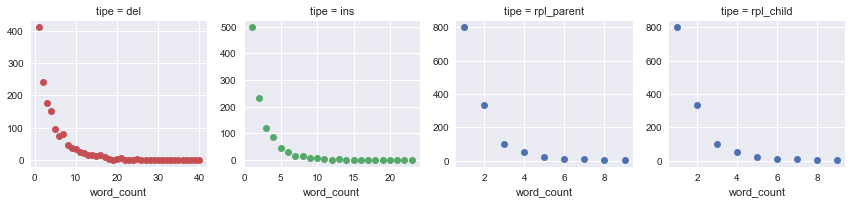

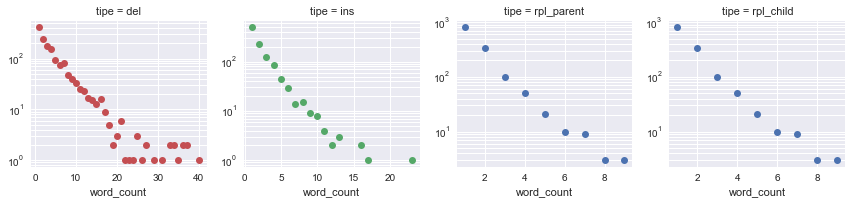

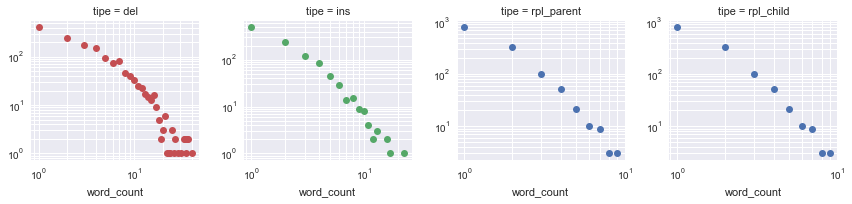

In [47]:
g = sb.FacetGrid(word_chunk_counts,
                 col='tipe', col_order=columns_size[:4],
                 hue='tipe',
                 palette=[red, green, blue, blue],
                 #size=5,
                 sharex=False, sharey=False)
g.map(plot_int_dist, 'word_count')

g = sb.FacetGrid(word_chunk_counts,
                 col='tipe', col_order=columns_size[:4],
                 hue='tipe',
                 palette=[red, green, blue, blue],
                 #size=5,
                 sharex=False, sharey=False)
g.map(plot_int_dist, 'word_count', scale='ylog')

g = sb.FacetGrid(word_chunk_counts,
                 col='tipe', col_order=columns_size[:4],
                 hue='tipe',
                 palette=[red, green, blue, blue],
                 #size=5,
                 sharex=False, sharey=False)
g.map(plot_int_dist, 'word_count', scale='loglog');

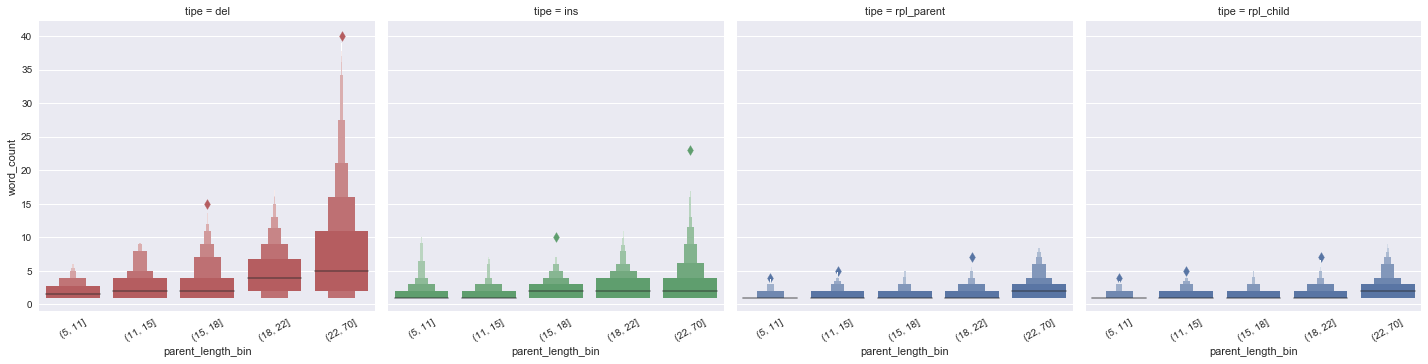

In [48]:
g = sb.FacetGrid(word_chunk_counts,
                 col='tipe', col_order=columns_size[:4],
                 hue='tipe',
                 palette=[red, green, blue, blue],
                 size=5)
g.map(sb.lvplot, 'parent_length_bin', 'word_count')
g.set_xticklabels(rotation=30)

### Chunk counts

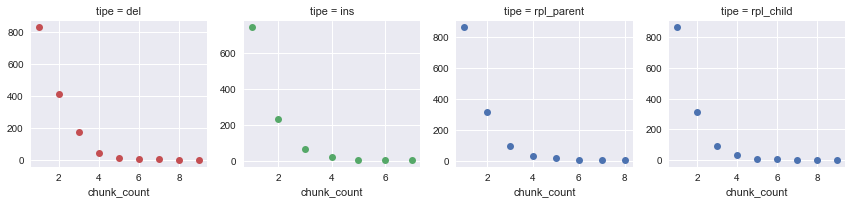

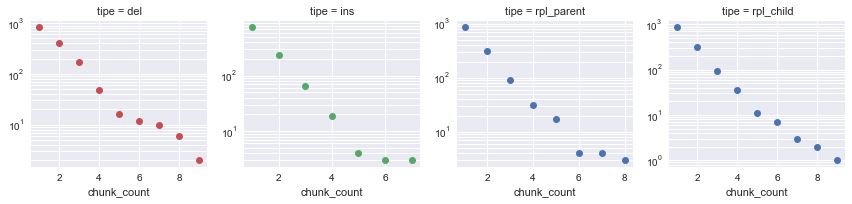

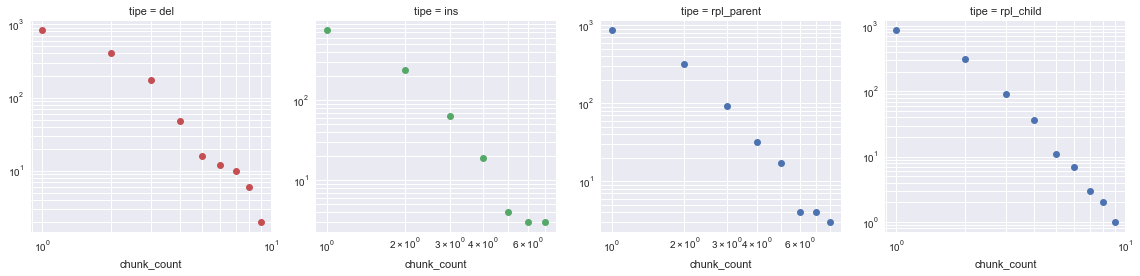

In [49]:
g = sb.FacetGrid(word_chunk_counts,
                 col='tipe', col_order=columns_size[:4],
                 hue='tipe',
                 palette=[red, green, blue, blue],
                 sharex=False, sharey=False)
g.map(plot_int_dist, 'chunk_count')

g = sb.FacetGrid(word_chunk_counts,
                 col='tipe', col_order=columns_size[:4],
                 hue='tipe',
                 palette=[red, green, blue, blue],
                 sharex=False, sharey=False)
g.map(plot_int_dist, 'chunk_count', scale='ylog')

g = sb.FacetGrid(word_chunk_counts,
                 col='tipe', col_order=columns_size[:4],
                 hue='tipe',
                 palette=[red, green, blue, blue],
                 size=4,
                 sharex=False, sharey=False)
g.map(plot_int_dist, 'chunk_count', scale='loglog')
g.set_xticklabels()

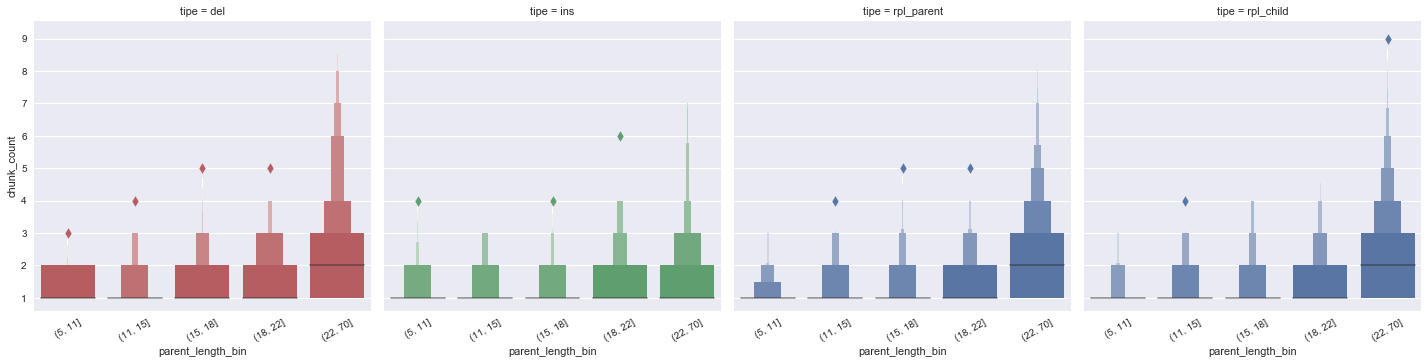

In [50]:
g = sb.FacetGrid(word_chunk_counts,
                 col='tipe', col_order=columns_size[:4],
                 hue='tipe',
                 palette=[red, green, blue, blue],
                 size=5)
g.map(sb.lvplot, 'parent_length_bin', 'chunk_count')
g.set_xticklabels(rotation=30)

### Chunk sizes

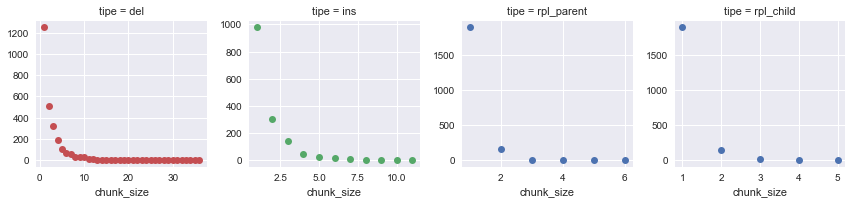

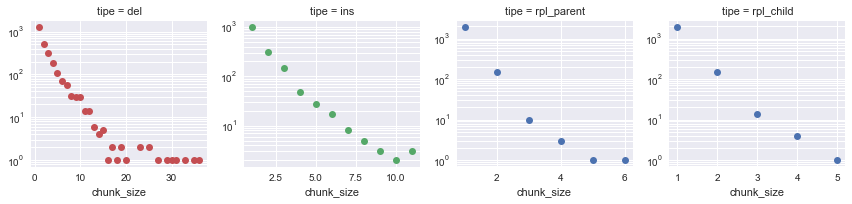

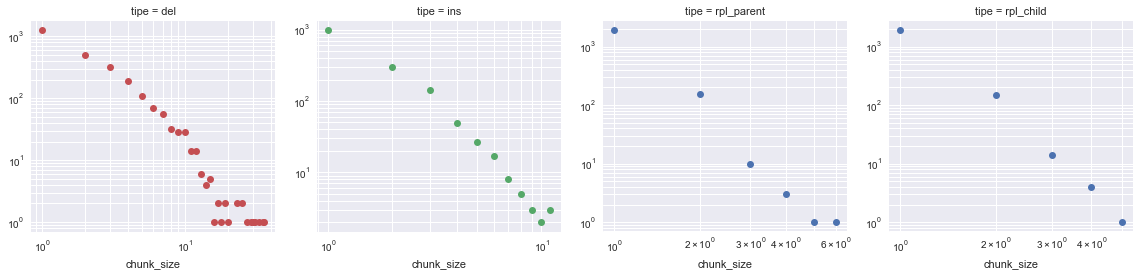

In [51]:
g = sb.FacetGrid(data_size, col='tipe', col_order=columns_size[:4],
                 hue='tipe', hue_order=columns_size[:4],
                 palette=[red, green, blue, blue],
                 sharex=False, sharey=False, size=3)
g.map(plot_int_dist, 'chunk_size')

g = sb.FacetGrid(data_size, col='tipe', col_order=columns_size[:4],
                 hue='tipe', hue_order=columns_size[:4],
                 palette=[red, green, blue, blue],
                 sharex=False, sharey=False, size=3)
g.map(plot_int_dist, 'chunk_size', scale='ylog')

g = sb.FacetGrid(data_size, col='tipe', col_order=columns_size[:4],
                 hue='tipe', hue_order=columns_size[:4],
                 palette=[red, green, blue, blue],
                 sharex=False, sharey=False, size=4)
g.map(plot_int_dist, 'chunk_size', scale='loglog')
g.set_xticklabels()

In [52]:
def weighted_std(values, weights, ddof=0):
    avg = np.average(values, weights=weights)
    variance, n = np.average((values - avg)**2, weights=weights, returned=True)
    return np.sqrt(variance * n / (n - ddof))

def plot_size_positions(**kwargs):
    data = kwargs['data']
    ax = kwargs.get('ax', plt.gca())
    color = kwargs.get('color', 'blue')
    bins = kwargs.get('bins', 10)
    tipe_r = data.iloc[0].tipe_r
    
    # Compute bin heights
    heights = np.zeros(bins)
    cis = np.zeros(bins)
    step = 1 / bins
    for i in range(bins):
        limits = [i * step, (i + 1) * step]
        contributions = (bound(limits, data['chunk_stop']) - bound(limits, data['chunk_start'])) / step
        # The height of a bin is the average size of chunks which have words in it.
        # But if a chunk touches a bin only partially, it contributes only that portion
        # to the height of the bin (which is what 'contributions' measures).
        # We further weigh the sizes by pre-computed weights which embody what entities we 
        # consider independent (trees or transformations).
        heights[i] = ((data.weight * contributions * data.chunk_size).sum()
                      / (data.weight * contributions).sum())
        wn = (data.weight * contributions).sum()
        wstd = weighted_std(data.chunk_size, weights=data.weight * contributions, ddof=1)
        cis[i] = wstd * stats.t.ppf(1 - .05/2, wn - 1) / np.sqrt(wn)
    total = sum(heights)
    print(tipe_r)
    print(heights)
    
    # Plot them.
    x = np.linspace(0, 1, bins)
    ax.plot(x, heights, color=color, label=tipe_r)
    ax.fill_between(x, heights - cis, heights + cis,
                    color=sb.desaturate(color, 0.2), alpha=0.2)
    ax.set_xlim(x[0], x[-1])

$\mathcal{D}$
[ 4.20221559  4.73210519  5.5681069   5.44539768]
$\mathcal{I}$
[ 2.04691588  2.32543445  2.70941768  2.67606907]
$\mathcal{R}_p$
[ 1.14960568  1.12064641  1.25488146  1.13127419]
$\mathcal{R}_c$
[ 1.12690385  1.129933    1.28640954  1.16940016]
stb_parent
[ 12.05280558  12.67756925  12.70897943  12.00568249]
stb_child
[ 12.32723366  12.82804518  12.82419223  12.20822774]


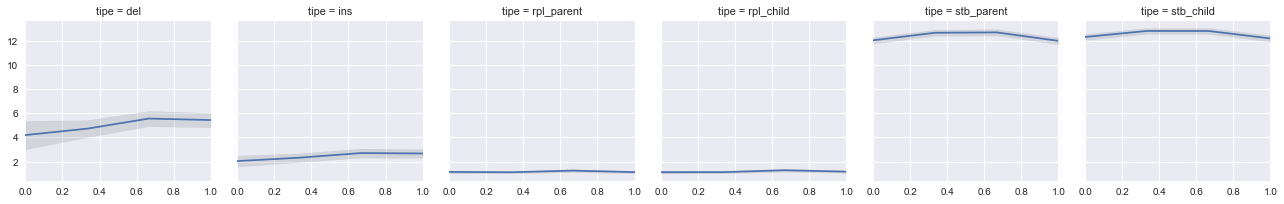

In [53]:
g = sb.FacetGrid(data=data_size, col='tipe', col_order=columns_size,
                 size=3,
                 sharex=True, sharey=True)
g.map_dataframe(plot_size_positions, bins=4)

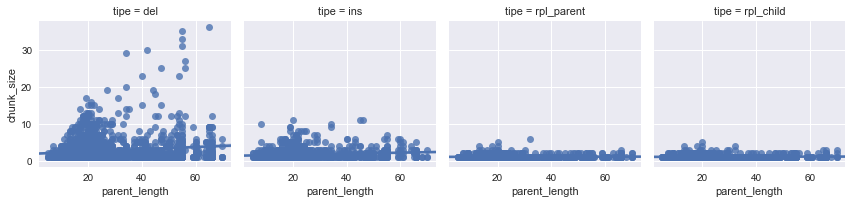

In [54]:
g = sb.FacetGrid(data=data_size, col='tipe', col_order=columns_size[:4],
                 size=3,
                 sharex=True, sharey=True)
g.map(sb.regplot, 'parent_length', 'chunk_size')

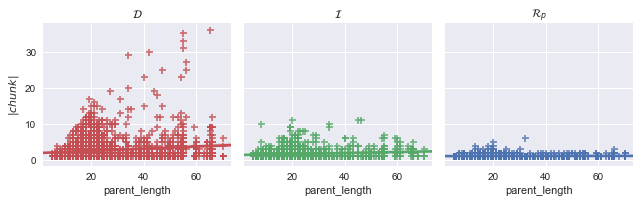

In [55]:
g = sb.FacetGrid(data=data_size,
                 col='tipe_r', col_order=columns_size_r[:3],
                 hue='tipe_r', hue_order=columns_size_r[:3],
                 palette=[red, green, blue],
                 size=3,
                 sharex=True, sharey=True)
g.map(sb.regplot, 'parent_length', 'chunk_size', marker='+')
g.set_titles('{col_name}')
g.set_ylabels(r'$|chunk|$')

In [56]:
for tipe in columns_size[:3]:
    print(tipe)
    res = stats.linregress(data_size[data_size.tipe == tipe].parent_length,
                           data_size[data_size.tipe == tipe].chunk_size)
    print(res)
    print('1 / slope =', 1 / res.slope)
    print()

del
LinregressResult(slope=0.029970467939982391, intercept=1.9257082296194046, rvalue=0.13966592917133402, pvalue=5.0801788600630809e-13, stderr=0.0041284251325100791)
1 / slope = 33.3661790668

ins
LinregressResult(slope=0.013469342880934591, intercept=1.3923408271271303, rvalue=0.12990674458119297, pvalue=3.12978076292201e-07, stderr=0.0026214449551683118)
1 / slope = 74.2426715869

rpl_parent
LinregressResult(slope=0.00081295849323353064, intercept=1.0738588478130933, rvalue=0.031084110140652082, pvalue=0.15875317441778103, stderr=0.00057665240353656905)
1 / slope = 1230.07510017



$\mathcal{D}$
[ 1.7811833   1.98130498  1.88945315  2.24002123  2.52045854  2.26504705]
$\mathcal{D}$
[ 1.70573703  2.07387477  3.21262965  3.80242901  3.8317124   4.13697412]
$\mathcal{D}$
[ 2.83339195  3.15722977  4.76883983  5.1706141   4.85530083  4.74804281]
$\mathcal{D}$
[ 4.56251026  5.2057548   5.43811443  5.73911545  5.87041186  5.93440903]
$\mathcal{D}$
[ 7.73741302  6.06180319  7.5612967   9.21717466  8.95416966  8.11592567]
$\mathcal{I}$
[ 1.80195865  1.79581521  1.89627572  2.57716687  2.23943897  2.4044284 ]
$\mathcal{I}$
[ 1.70636391  1.64769303  1.82952923  1.50869631  1.70370341  1.67179605]
$\mathcal{I}$
[ 1.76573737  2.03444869  2.40956545  2.57901923  2.65312533  2.34347919]
$\mathcal{I}$
[ 2.12630976  2.84943396  2.72917138  3.17725538  3.3846495   2.94876408]
$\mathcal{I}$
[ 2.69905318  2.27829968  2.69570823  2.88489111  3.10375769  3.47351454]
$\mathcal{R}_p$
[ 1.07469805  1.14294298  1.0395362   1.16231029  1.15843621  1.03091583]
$\mathcal{R}_p$
[ 1.54753099  

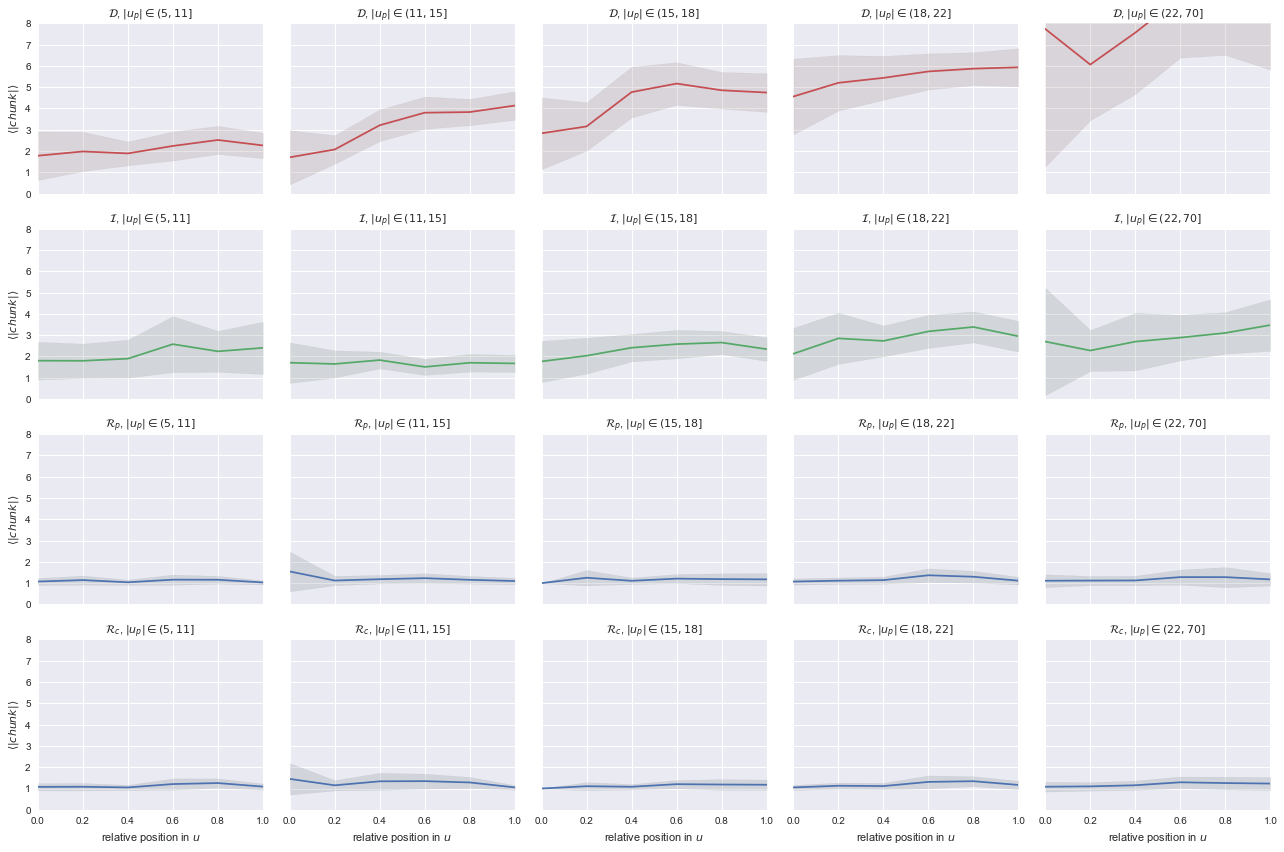

In [57]:
data_size['parent_length_bin'] = pd.cut(data_size.parent_length, sentence_bins)

g = sb.FacetGrid(data=data_size,#[data_size.parent_length <= long_sentence],
                 row='tipe_r', row_order=columns_size_r[:4],
                 hue='tipe_r', hue_order=columns_size_r[:4],
                 palette=[red, green, blue, blue],
                 col='parent_length_bin',
                 size=3, aspect=1.2,
                 sharex=True, sharey=True)
g.map_dataframe(plot_size_positions, bins=6)
g.set_titles('{row_name}, $|u_p| \\in {col_name}$')
g.set_ylabels(r'$\left< |chunk| \right>$')
g.set_xlabels('relative position in $u$')
g.set(ylim=(0, 8))
g.fig.tight_layout()

### Paper figures

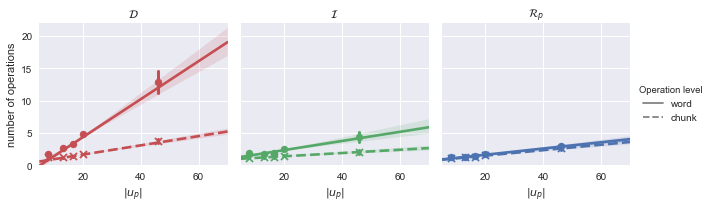

In [58]:
word_chunk_counts['tipe_r'] = word_chunk_counts.tipe.apply(lambda t: tipe_to_tex.get(t, t))
g = sb.FacetGrid(word_chunk_counts[word_chunk_counts.tipe_r.isin(columns_size_r[:3])],
                 col='tipe_r', col_order=columns_size_r[:3],
                 hue='tipe_r',
                 palette=[red, green, blue, blue],
                 size=3,
                 xlim=(word_chunk_counts.parent_length.min(), word_chunk_counts.parent_length.max()),
                 ylim=(0, 22))
g.axes[0, 0].plot([], [], color='grey', label='word')
g.axes[0, 0].plot([], [], color='grey', linestyle='dashed', label='chunk')
g.map(sb.regplot, 'parent_length', 'word_count', x_bins=(sentence_bins[1:] + sentence_bins[:-1]) / 2)
g.map(sb.regplot, 'parent_length', 'chunk_count', x_bins=(sentence_bins[1:] + sentence_bins[:-1]) / 2,
      line_kws={'linestyle': 'dashed'}, marker='x')
g.set_titles('{col_name}')
g.set_ylabels('number of operations')
g.set_xlabels('$|u_p|$')
g.add_legend(title='Operation level', label_order=['word', 'chunk'])
if SAVE_FIGURES:
    g.fig.savefig(FIG.format('chunk-size_parent-length'), dpi=300, bbox_inches='tight')

In [59]:
for tipe in columns_size[:3]:
    print(tipe)
    res = stats.linregress(word_chunk_counts[word_chunk_counts.tipe == tipe].parent_length,
                           word_chunk_counts[word_chunk_counts.tipe == tipe].word_count)
    print(res)
    print('1 / slope =', 1 / res.slope)
    print()

del
LinregressResult(slope=0.29381858963725588, intercept=-1.5228921567799629, rvalue=0.58250578005812637, pvalue=1.8808353932976144e-137, stderr=0.010575415181745542)
1 / slope = 3.40346062254

ins
LinregressResult(slope=0.070676028056477394, intercept=0.94595041954280012, rvalue=0.33160529868713362, pvalue=6.6428722956930867e-29, stderr=0.0061498720025254371)
1 / slope = 14.1490690337

rpl_parent
LinregressResult(slope=0.048189315170394174, intercept=0.68317497977659913, rvalue=0.43479524511014683, pvalue=2.0864973670577101e-62, stderr=0.0027398600174708982)
1 / slope = 20.7514880937



$\mathcal{D}$
[ 4.17951576  4.29066406  4.88528451  5.54880048  5.56294764  5.40140722]
$\mathcal{I}$
[ 1.97617043  2.17907144  2.36759047  2.6698542   2.77235119  2.62337094]
$\mathcal{R}_p$
[ 1.13616942  1.1419679   1.12176324  1.25534988  1.2131534   1.11110652]
$\mathcal{D}$
[ 1.7811833   1.98130498  1.88945315  2.24002123  2.52045854  2.26504705]
$\mathcal{I}$
[ 1.80195865  1.79581521  1.89627572  2.57716687  2.23943897  2.4044284 ]
$\mathcal{R}_p$
[ 1.07469805  1.14294298  1.0395362   1.16231029  1.15843621  1.03091583]
$\mathcal{D}$
[ 1.70573703  2.07387477  3.21262965  3.80242901  3.8317124   4.13697412]
$\mathcal{I}$
[ 1.70636391  1.64769303  1.82952923  1.50869631  1.70370341  1.67179605]
$\mathcal{R}_p$
[ 1.54753099  1.12189933  1.1841941   1.23278606  1.15553662  1.09911495]
$\mathcal{D}$
[ 2.83339195  3.15722977  4.76883983  5.1706141   4.85530083  4.74804281]
$\mathcal{I}$
[ 1.76573737  2.03444869  2.40956545  2.57901923  2.65312533  2.34347919]
$\mathcal{R}_p$
[ 1.      

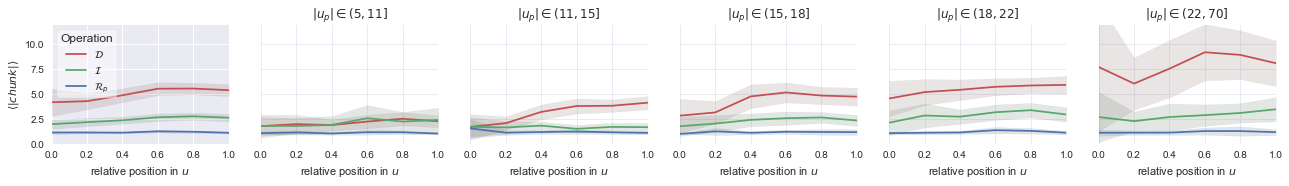

In [60]:
fig, axes = plt.subplots(1, 6, figsize=(18, 2.75), sharex=True, sharey=True)

for tipe_r, color in zip(columns_size_r[:3], [red, green, blue]):
    plot_size_positions(data=data_size[(data_size.tipe_r == tipe_r)],
                        color=color, bins=6, ax=axes[0])
axes[0].set_xlabel('relative position in $u$')
axes[0].set_ylabel(r'$\left< |chunk| \right>$')
legend = axes[0].legend(title='Operation', loc='upper left', frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_alpha(.5)

for i, sbin in enumerate(sorted(set(data_size.parent_length_bin).difference([np.nan]))):
    for tipe_r, color in zip(columns_size_r[:3], [red, green, blue]):
        plot_size_positions(data=data_size[#(data_size.parent_length <= long_sentence) &
                                           (data_size.tipe_r == tipe_r)
                                           & (data_size.parent_length_bin == sbin)],
                            color=color, bins=6, ax=axes[i+1])
    axes[i+1].set_xlabel('relative position in $u$')
    axes[i+1].set_title(r'$|u_p| \in {}$'.format(sbin))
    axes[i+1].set_facecolor('white')
    axes[i+1].grid(color='#EAEAF2')

axes[0].set_ylim(0, 12)
fig.tight_layout()

if SAVE_FIGURES:
    fig.savefig(FIG.format('chunk-size_position_parent-length'), dpi=300, bbox_inches='tight')

## 10 Burstiness of it all

First a few helpers

In [61]:
def burstiness(inter_events):
    s = inter_events.std()
    m = inter_events.mean()
    return (s - m) / (s + m)

In [62]:
def intervals(ids):
    last_end = None
    for chunk in contiguous_chunks(ids):
        if last_end is not None:
            yield chunk[0] - last_end - 1
        last_end = chunk[-1]
        yield from (len(chunk) - 1) * [0]

In [63]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

In [64]:
def powerset_nonempty(iterable):
    return itertools.islice(powerset(iterable), 1, None)

### 10.1 Bursts of transformations in a sentence

FIXME: burstiness is computed as if trees were the independent items, whereas the rest is computed with sentences as the independent items

Prepare the data

In [65]:
data_size_intervals = []
for tree in ProgressBar(max_value=Tree.objects.experiment.count())(Tree.objects.experiment):
    
    for head in tree.root.children.kept:
        
        for parent, child in pairwise(branch_sentences(head, with_root=True, with_leaf=True)):
            
            app_ids, dis_ids, rpl_pairs, stb_pairs = \
                consensus_chunk_indices_with_children(parent, child)
            
            for tipe_ids in itertools.chain(
                    powerset_nonempty([('del', dis_ids),
                                       ('rpl_parent', [p[0] for p in rpl_pairs])]),
                    powerset_nonempty([('ins', app_ids),
                                       ('rpl_child', [p[1] for p in rpl_pairs])])):
                tipe, ids = zip(*tipe_ids)
                ids = list(itertools.chain(*ids))
                tipe = '+'.join(tipe)
                for interval in intervals(ids):
                    data_size_intervals.append({
                        'tree_id': tree.id,
                        'branch_id': head.id,
                        'parent_id': parent.id,
                        'child_id': child.id,

                        'parent_depth': parent.depth,
                        'parent_length': len(parent.tokens),

                        'tipe': tipe,
                        'interval_size': interval
                    })

data_size_intervals = pd.DataFrame(data_size_intervals)

100% (50 of 50) |#########################| Elapsed Time: 0:00:23 Time: 0:00:23


Compute burstinesses for all combinations of transformations, with zero-valued intervals

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.



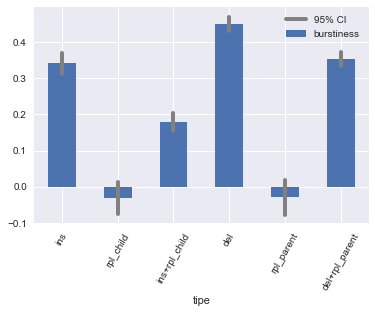

In [66]:
order = ['+'.join(t) for t in itertools.chain(powerset_nonempty(['ins', 'rpl_child']),
                                              powerset_nonempty(['del', 'rpl_parent']))]
word_burstiness = pd.DataFrame({
    'burstiness': data_size_intervals
         .groupby(['tree_id', 'tipe'])
         .interval_size
         .aggregate(burstiness)
})

word_burstiness['ci'] = word_burstiness.burstiness
word_burstiness = word_burstiness\
    .groupby(level=1)\
    .aggregate({
        'burstiness': 'mean',
        'ci': lambda x: x.std(ddof=1) * stats.t.ppf(1 - .05/2, x.size - 1) / np.sqrt(x.size)
    }).loc[order]

ax = word_burstiness.burstiness.plot(kind='bar', figsize=(6, 4), rot=60)
for i, row in enumerate(order):
    b = word_burstiness.loc[row].burstiness
    ci = word_burstiness.loc[row].ci
    ax.plot([i, i], [b - ci, b + ci], lw=4, color='grey',
            label='95% CI' if i == 0 else None)
ax.legend()

In [67]:
def plot_burstinesses(burstiness, ops, colors, labels, ylabel, title,
                      ax=None, xlim=None, labelsrot=0):
    if ax is None:
        ax = plt.gca()
    ax.bar(range(len(ops)), burstiness.burstiness.loc[ops], color=colors)
    ax.set_xticks(range(len(ops)))
    ax.set_xticklabels(labels, rotation=labelsrot)
    for i, row in enumerate(ops):
        b = burstiness.loc[row].burstiness
        ci = burstiness.loc[row].ci
        ax.plot([i, i], [b - ci, b + ci], lw=4, color='grey',
                label='95% CI' if i == 0 else None)
    ax.set_xlim(xlim)
    xlim = ax.get_xlim()
    ax.plot(xlim, [0, 0], color='grey', linestyle='--', lw=2)
    ax.legend()
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    return ax

blue, green, red, purple, yellow, cyan = sb.color_palette()

Separated by parent and child utterance, then the combination of all

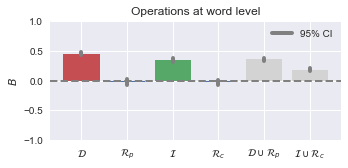

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))
plot_burstinesses(word_burstiness,
                  ['del', 'rpl_parent', 'ins', 'rpl_child', 'del+rpl_parent', 'ins+rpl_child'],
                  [red, blue, green, blue, 'lightgrey', 'lightgrey'],
                  ['$\mathcal{D}$', '$\mathcal{R}_p$', '$\mathcal{I}$', '$\mathcal{R}_c$',
                   '$\mathcal{D} \cup \mathcal{R}_p$', '$\mathcal{I} \cup \mathcal{R}_c$'],
                  '$B$', 'Operations at word level', ax=ax)
ax.set_ylim(-1, 1)
fig.tight_layout()
if SAVE_FIGURES:
    fig.savefig(FIG.format('burstiness-words'), dpi=300, bbox_inches='tight')

In [69]:
ax.get_position()

Bbox([[0.15475, 0.18533333333333335], [0.964, 0.8499618055555556]])

In [70]:
.964 - .15475

0.80925

Now without zero-valued intervals, i.e. burstiness of chunks of events

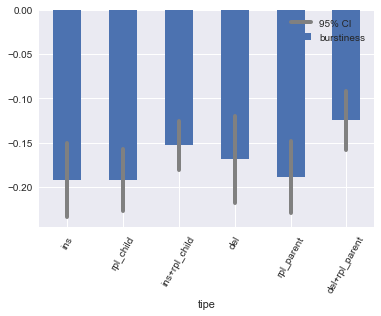

In [71]:
chunk_burstiness = pd.DataFrame({
    'burstiness': data_size_intervals[data_size_intervals.interval_size > 0]
         .groupby(['tree_id', 'tipe'])
         .interval_size
         .aggregate(burstiness)
})

chunk_burstiness['ci'] = chunk_burstiness.burstiness
chunk_burstiness = chunk_burstiness\
    .groupby(level=1)\
    .aggregate({
        'burstiness': 'mean',
        'ci': lambda x: x.std(ddof=1) * stats.t.ppf(1 - .05/2, x.size - 1) / np.sqrt(x.size)
    }).loc[order]

ax = chunk_burstiness.burstiness.plot(kind='bar', figsize=(6, 4), rot=60)
for i, row in enumerate(order):
    b = chunk_burstiness.loc[row].burstiness
    ci = chunk_burstiness.loc[row].ci
    ax.plot([i, i], [b - ci, b + ci], lw=4, color='grey',
            label='95% CI' if i == 0 else None)
ax.legend()

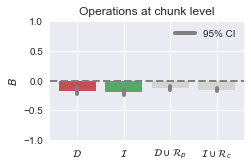

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(5 * (1-.809) + 5 * (2/3) * .809, 2.5))
plot_burstinesses(chunk_burstiness,
                  ['del', 'ins', 'del+rpl_parent', 'ins+rpl_child'],
                  [red, green, 'lightgrey', 'lightgrey'],
                  ['$\mathcal{D}$', '$\mathcal{I}$',
                   '$\mathcal{D} \cup \mathcal{R}_p$', '$\mathcal{I} \cup \mathcal{R}_c$'],
                  '$B$', 'Operations at chunk level', ax=ax)
ax.set_ylim(-1, 1)
fig.tight_layout()
if SAVE_FIGURES:
    fig.savefig(FIG.format('burstiness-chunks'), dpi=300, bbox_inches='tight')

So if you compress chunks to a single event, it's not bursty at all.

### 10.2 Bursts of sentence transformations in a branch

Prepare the data

In [73]:
stabilities0 = []
for branch_id in set(data.branch_id):
    # We ignore exchanges here too
    child_depths = 1 + data[(data.branch_id == branch_id)
                            & (data.ins_count == 0)
                            & (data.del_count == 0)
                            & (data.rpl_count == 0)].parent_depth
    for contiguous_stability in contiguous_chunks(child_depths):
        stabilities0.append({
            'tree_id': data[data.branch_id == branch_id].iloc[0].tree_id,
            'branch_id': branch_id,
            'duration': len(contiguous_stability),
            # Only account for unobserved end of stabilities due to branch cutoff, not spam
            'observed': max(contiguous_stability) < config.target_branch_depth
        })
    for chunk in contiguous_chunks(set(1 + data[data.branch_id == branch_id].parent_depth)
                                   .difference(child_depths)):
        stabilities0.extend((len(chunk) - 1) * [{
            'tree_id': data[data.branch_id == branch_id].iloc[0].tree_id,
            'branch_id': branch_id,
            'duration': 0,
            'observed': True
        }])

stabilities0 = pd.DataFrame(stabilities0)

Burstiness using all stabilities or observed-only, with or without zero-valued intervals

In [74]:
sentence_burstiness = pd.DataFrame({
    'all': stabilities0
         .groupby(['tree_id'])
         .duration
         .aggregate(burstiness),
    'observed-only': stabilities0[stabilities0.observed]
         .groupby(['tree_id'])
         .duration
         .aggregate(burstiness),
    'chunk all': stabilities0[stabilities0.duration > 0]
         .groupby(['tree_id'])
         .duration
         .aggregate(burstiness),
    'chunk observed-only': stabilities0[(stabilities0.duration > 0) & stabilities0.observed]
         .groupby(['tree_id'])
         .duration
         .aggregate(burstiness)
})

for flavour in ['all', 'observed-only', 'chunk all', 'chunk observed-only']:
    avg = sentence_burstiness[flavour].mean()
    print("Sentence burstiness ({}) = {}".format(flavour, avg))
    ci = (sentence_burstiness[flavour].std(ddof=1)
          * stats.t.ppf(1 - .05/2, sentence_burstiness[flavour].size - 1)
          / np.sqrt(sentence_burstiness[flavour].size))
    print("CI ({}) = [{}, {}]".format(flavour, avg - ci, avg + ci))
    print()

Sentence burstiness (all) = 0.2519467032902166
CI (all) = [0.2233357794444081, 0.2805576271360251]

Sentence burstiness (observed-only) = 0.30428755788516143
CI (observed-only) = [0.2729107666100809, 0.33566434916024196]

Sentence burstiness (chunk all) = -0.23987588673378962
CI (chunk all) = [-0.2786346266874475, -0.20111714678013176]

Sentence burstiness (chunk observed-only) = -0.30462715242777333
CI (chunk observed-only) = [-0.3435485064671926, -0.26570579838835406]



And note that even for that last flavour, we have quite a few measures:

In [75]:
((stabilities0.duration > 0) & stabilities0.observed).sum()

500

## 12 Modelling

### 12.1 Super-simple per-word model

For each word of the parent sentence, we have the choice between deletion/insertion/replacement.

$$
p(e_n) \propto \begin{cases}
  p_d, & \text{for $e_n$ deletion} \\
  p_i, & \text{for $e_n$ insertion} \\
  p_r, & \text{for $e_n$ replacement} \\
  1 - \sum_{e'_n \neq \text{stability}} p(e'_n), & \text{for $e_n$ stability}
\end{cases}
$$

### 12.2 Per-word + chunkiness

For each word of the parent sentence:
* we have the choice between deletion/insertion/replacement
* with a different probability if the preceding event is of the same type

$$
p(e_n) \propto \begin{cases}
  p_d a_d^{\delta_{e_{n-1}, e_n}}, & \text{for $e_n$ deletion} \\
  p_i a_i^{\delta_{e_{n-1}, e_n}}, & \text{for $e_n$ insertion} \\
  p_r a_r^{\delta_{e_{n-1}, e_n}}, & \text{for $e_n$ replacement} \\
  1 - \sum_{e'_n \neq \text{stability}} p(e'_n), & \text{for $e_n$ stability}
\end{cases}
$$

### 12.3 Per-word + chunkiness + position-dependence

For each word of the parent sentence:
* we have the choice between deletion/insertion/replacement,
* with a different probability if the preceding event is of the same type
* and all probabilities depend on the position in the sentence

$$
p(e_n) \propto \begin{cases}
  \frac{1}{1 + e^{- a_d^{\delta_{e_{n-1}, e_n}} - \gamma_d - \beta_d n}}, & \text{for $e_n$ deletion} \\
  \frac{1}{1 + e^{- a_i^{\delta_{e_{n-1}, e_n}} - \gamma_i - \beta_i n}}, & \text{for $e_n$ insertion} \\
  \frac{1}{1 + e^{- a_r^{\delta_{e_{n-1}, e_n}} - \gamma_r - \beta_r n}}, & \text{for $e_n$ replacement} \\
  1 - \sum_{e'_n \neq \text{stability}} p(e'_n), & \text{for $e_n$ stability}
\end{cases}
$$

### 12.4 Per-word + chunkiness + position-dependence + sentence length-dependence

For each word of the parent sentence:
* we have the choice between deletion/insertion/replacement,
* with a different probability if the preceding event is of the same type
* all probabilities depend on the position in the sentence
* all probabilities depend on the overall length of the sentence

### 12.5 Per-word + event-dependent chunkiness + position-dependence + sentence length-dependence

For each word of the parent sentence:
* we have the choice between deletion/insertion/replacement,
* with a different probability depending on the type of the preceding event (i.e. compare to all event types, not only the same one)
* all probabilities depend on the position in the sentence
* all probabilities depend on the overall length of the sentence

### 12.6 Per-word + event-dependent chunkiness + position-dependence + sentence length-dependence + memory

For each word of the parent sentence:
* we have the choice between deletion/insertion/replacement,
* with a different probability depending on the type of the preceding event (i.e. compare to all event types, not only the same one)
* all probabilities depend on the position in the sentence
* all probabilities depend on the overall length of the sentence
* for deletion and insertion, the probability depends on the proportion of events of opposite type in a preceding window

### 12.7 Per-word-and-block

For each word of the parent sentence:
* we have the choice between deletion/insertion/replacement
* we choose a size for the block we create, according to some distribution whose average does not depend on the position in the sentence

### 12.8 Per-word-and-block + position-dependence

For each word of the parent sentence:
* we have the choice between deletion/insertion/replacement
* that choice depends on the position in the sentence
* we choose a size for the block we create, according to some distribution whose average does not depend on the position in the sentence

### 12.9 Per-word-and-block + position-dependence + sentence-length dependence

For each word of the parent sentence:
* we have the choice between deletion/insertion/replacement
* that choice depends on the position in the sentence
* we choose a size for the block we create, according to some distribution whose average does not depend on the position in the sentence, but whose variance depends on the overall length of the sentence

### 12.10 Per-word-and-block + position-dependence + sentence-length dependence + memory

For each word of the parent sentence:
* we have the choice between deletion/insertion/replacement
* that choice depends on the position in the sentence
* for deletions and insertions, it also depends on the distance to the closest opposite transformation
* we choose a size for the block we create, according to some distribution whose average does not depend on the position in the sentence, but whose variance depends on the overall length of the sentence
* for deletions and insertions, the size of the block depends on the proportion of opposite transformations in a preceding window